In [1]:
!nvidia-smi --query-gpu=gpu_name --format=csv

name
Tesla T4


In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/coin-wear-estimator/notebook')
!pip3 install -r ../requirements.txt --quiet
!apt install -qq ocl-icd-* opencl-headers 

Mounted at /content/drive
     |████████████████████████████████| 911kB 6.9MB/s 
     |████████████████████████████████| 346.3MB 47kB/s 
     |████████████████████████████████| 13.1MB 257kB/s 
     |████████████████████████████████| 50.4MB 62kB/s 
     |████████████████████████████████| 56.4MB 54kB/s 
     |████████████████████████████████| 296kB 56.7MB/s 
     |████████████████████████████████| 3.4MB 25.8MB/s 
     |████████████████████████████████| 81kB 12.5MB/s 
     |████████████████████████████████| 880kB 41.3MB/s 
     |████████████████████████████████| 8.3MB 22.6MB/s 
     |████████████████████████████████| 71kB 11.1MB/s 
     |████████████████████████████████| 59.9MB 52kB/s 
     |████████████████████████████████| 317kB 54.5MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
ERROR: h2o4gpu 0.4.1 has requirement scikit-learn==0.21.2, but you'll have scikit-learn 0.22.2.post1 which is incompatible.
ocl-icd-l

In [ ]:
%load_ext autoreload
%autoreload 2

import sys
if ".." not in sys.path:
  sys.path.append("..")
from src.utils import *
from src.detector import crop_coin, create_circular_mask
import pandas as pd
import seaborn as sns
import numpy as np
import itertools
import cv2
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import os
from scipy import ndimage
from scipy.spatial import distance
from sklearn.cluster import KMeans
from bunch import Bunch
from sklearn.model_selection import train_test_split
import random
import collections
from silx.opencl import sift as silx_sift
# from sklearn.cluster import KMeans
from h2o4gpu.solvers import KMeans
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics.pairwise import chi2_kernel
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import time
import copy
from torch.utils.data import Dataset, TensorDataset, DataLoader
from PIL import Image

# Labels preparation

In [ ]:
def get_design_mask(master_coin):
    im = cv2.cvtColor(master_coin, cv2.COLOR_BGR2GRAY)
    im = cv2.medianBlur(im, 3)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (4,4))
    im = cv2.dilate(im, kernel ,iterations = 1)

    back = cv2.GaussianBlur(im, (61,61), 0)
    im = im.astype("float")
    im = np.subtract(im, back)
    im = im + np.mean(back)
    mask = create_circular_mask(im.shape[0], im.shape[1])
    im[~mask] = 0
    im[im < 0] = 0
    im[im > 255] = 255
    im = np.uint8(im)

    im = cv2.Canny(im, 14, 30)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    im = cv2.dilate(im, kernel ,iterations = 1)

    return im

In [ ]:
def coins_with_no_grade(df):
    df = df[df["title_state"].isna() & df["description_state"].isna()]
    return df 

def coins_with_ambiguity(df):
    df = df[df["title_state"].str.replace(" ","") != df["description_state"].str.replace(" ","")]
    df = df[df["title_state"].notna() & df["description_state"].notna()]
    return df

def unify_states(df):
    df = df[~df.index.isin(coins_with_no_grade(df).index)]
    df = df[~df.index.isin(coins_with_ambiguity(df).index)]
    df["state"] = df["title_state"]
    df.loc[df["state"].isna(), "state"] = df["description_state"]
    df.drop(["description_state", "title_state"], axis=1, inplace = True)
    return df

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def get_nearest_category_value(grade, categories=["1", "2", "3"]):
    basic_grading_dict_inv = {v: k for k, v in basic_grading_dict.items()}
    categories_in_sheldon = [basic_grading_dict[cat] for cat in categories]
    nearest_sheldon_value = find_nearest(categories_in_sheldon, grade)
    return basic_grading_dict_inv[nearest_sheldon_value]
    
def get_circulate_category(grade):
    if grade >= 60:
        return "1"
    elif grade >= 50:
        return "2"
    else:
        return "3"

def calculate_sheldon_and_categories(df, categories=["1","1-","2","2-","3"]):
    df = unify_states(df)
    df["sheldon"] = df["state"].apply(get_shaldon_value)
    # df["category"] = df["sheldon"].apply(lambda grade: get_nearest_category_value(grade, categories))
    df["category"] = df["sheldon"].apply(lambda grade: get_circulate_category(grade))
    return df

# Dataset reading

In [ ]:
def load_dataset(
    dataset_path=MARCINIAK_DATASET_PATH,
    h5_path=None,
    categories=["1", "2", "3"],
    ds_shape=(700,700)
    separate_sides=True
    ):
    dataset = Bunch(X=[], y=[], side=[])
    
    if h5_path is not None:
        with h5py.File(h5_path, 'r') as f:
          for k in f.keys():
              dataset[k] = np.asarray(f[k])
        return dataset

    metadata_df = pd.read_csv(metadata_path(dataset_path), sep="|")
    metadata_df = calculate_sheldon_and_categories(metadata_df, categories)
    side_df = pd.read_csv(side_path(dataset_path)).set_index("name")
    names = os.listdir(aligned_coins_path(dataset_path))
    names = sorted([n for n in names if n.split(".")[-1] == "jpg"])

    pbar = tqdm(total=len(names))
    for name in names:
        side = int(side_df.loc[name, "label"])
        index = int(name.split("_")[0])
        try:
            label = int(metadata_df.loc[index, "category"])
        except:
            pbar.update(1)
            continue
        im = cv2.imread("{}/{}".format(aligned_coins_path(dataset_path), name))
        im = cv2.resize(im, ds_shape)
        dataset.X.append(im)
        dataset.y.append(label)
        dataset.side.append(side)
        pbar.update(1)

    pbar.close()    
    return dataset

def join_datasets(datasets):
  new_dataset = Bunch()
  for k in datasets[0].keys():
    attr = list(itertools.chain.from_iterable([ ds[k] for ds in datasets]))
    new_dataset[k] = attr
  return new_dataset

def get_wear_marks(im, design_mask):
    # im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    im = cv2.resize(im, (700,700))
    # im = cv2.GaussianBlur(im, (3,3), 0.5)
    # im = cv2.medianBlur(im, 3)
    # im = cv2.Canny(im, 0.6*255, 0.8*255)

    # back = cv2.GaussianBlur(im, (61,61), 0)
    # im = im.astype("float")
    # im = np.subtract(im, back)
    # im = im + np.mean(back)
    # mask = create_circular_mask(im.shape[0], im.shape[1])
    # im[~mask] = 0

    # im[im < 0] = 0
    # im[im > 255] = 255
    # im = np.uint8(im)

    # im[design_mask.astype(bool)] = 0
    return im


def convert_to_wear_marks_dataset(dataset):
    master_coin_dict = { \
        1: cv2.imread(master_coins_path(MARCINIAK_DATASET_PATH) + "/1_general.jpg"), \
        2: cv2.imread(master_coins_path(MARCINIAK_DATASET_PATH) + "/2_general.jpg"), \
    }
    design_mask_dict = { \
        1: get_design_mask(master_coin_dict[1]), \
        2: get_design_mask(master_coin_dict[2]), \
    }

    X = []
    n = len(dataset.X)
    pbar = tqdm(total=n)
    for i in range(n):
        side = dataset.side[i]
        wear_marks = get_wear_marks(dataset.X[i], design_mask_dict[side])
        X.append(wear_marks)
        pbar.update(1)
    wear_marks_dataset = Bunch(X=X, y=dataset.y, side=dataset.side)
    pbar.close()  

    return wear_marks_dataset

def to_h5(dataset, fileName):
  with h5py.File(fileName, "w") as out:
    for k in dataset.keys():
      out[k] = dataset[k]

# Load Dataset

In [ ]:
%time

dataset = join_datasets([
  load_dataset(MARCINIAK_DATASET_PATH),
  load_dataset(NIEMCZYK_DATASET_PATH),
])
to_h5(dataset, "./dataset.h5")

# dataset = load_dataset(h5_path="dataset.h5")

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs


In [ ]:
len(dataset.X)

1160

In [ ]:
wear_marks_dataset = convert_to_wear_marks_dataset(dataset)

,date,description,images,link,title,title_state,description_state
0,"12 czerwca, 10:00",Opis pozycji\Stan zachowania: 2\Literatura: Ch...,['https://img1.onebid.pl/img/1482/433119_1b.jp...,https://aukcje.gndm.pl/pl/auction/1482/id/8146...,Sztandar 5 złotych 1930,NaN,2
1,06 lutego 2021,Opis pozycji\Stan zachowania: 2\Literatura: Ch...,['https://img1.onebid.pl/img/1236/386388_1b.jp...,https://aukcje.gndm.pl/pl/auction/1236/lot/333...,Sztandar 5 złotych 1930 - GŁĘBOKI,NaN,2
2,06 lutego 2021,Opis pozycji\Stan zachowania: 1-\Literatura: C...,['https://img1.onebid.pl/img/1236/330188_1b.jp...,https://aukcje.gndm.pl/pl/auction/1236/lot/333...,Sztandar 5 złotych 1930,NaN,1-
3,03 października 2020,Opis pozycji\Stan zachowania: NGC UNC\Literatu...,['https://img1.onebid.pl/img/996/261269_1b.jpg...,https://aukcje.gndm.pl/pl/auction/996/lot/3336...,Sztandar 5 złotych 1930,NaN,NGC UNC
4,03 października 2020,Opis pozycji\Stan zachowania: 2\Literatura: Ch...,['https://img1.onebid.pl/img/996/287431_1b.jpg...,https://aukcje.gndm.pl/pl/auction/996/lot/3337...,Sztandar 5 złotych 1930,NaN,2
...,...,...,...,...,...,...,...
158,"16 lutego 2010, 13:00",Opis pozycji\Estymacje: 0 EUR | 1 PLN\\\Nr poz...,['https://img1.onebid.pl/img/1000066/429009599...,https://aukcje.gndm.pl/pl/auction/1000066/id/5...,"1019. 5 zł 1930 Sztandar, st.3",3,NaN
159,"12 grudnia 2009, 21:36",Opis pozycji\Estymacje: 0 EUR | 1 PLN\\\Nr poz...,['https://img1.onebid.pl/img/1000066/429010378...,https://aukcje.gndm.pl/pl/auction/1000066/id/5...,"1565. 5 zł 1930 Sztandar, st.3+",3+,NaN
160,"17 grudnia 2008, 21:45",Opis pozycji\Estymacje: 0 EUR | 1 PLN\\\Nr poz...,['https://img1.onebid.pl/img/1000066/429009072...,https://aukcje.gndm.pl/pl/auction/1000066/id/5...,"3545. 5 zł 1930, Sztandar - NGC AU 55",NGC AU 55,NaN
161,"15 października 2008, 21:29",Opis pozycji\Estymacje: 0 EUR | 1 PLN\\\Nr poz...,['https://img1.onebid.pl/img/1000066/429008245...,https://aukcje.gndm.pl/pl/auction/1000066/id/4...,1466. 5 zł 1930 Sztandar,NaN,NaN


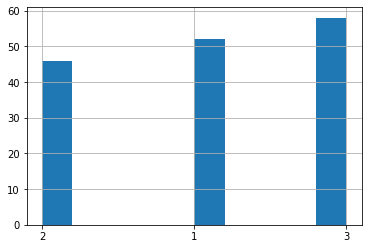

In [ ]:
metadata_df = pd.read_csv(metadata_path(MARCINIAK_DATASET_PATH), sep="|")
calculate_sheldon_and_categories(metadata_df)["category"].hist()


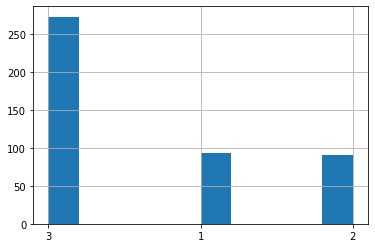

In [ ]:
metadata_df = pd.read_csv(metadata_path(NIEMCZYK_DATASET_PATH), sep="|")
calculate_sheldon_and_categories(metadata_df)["category"].hist()

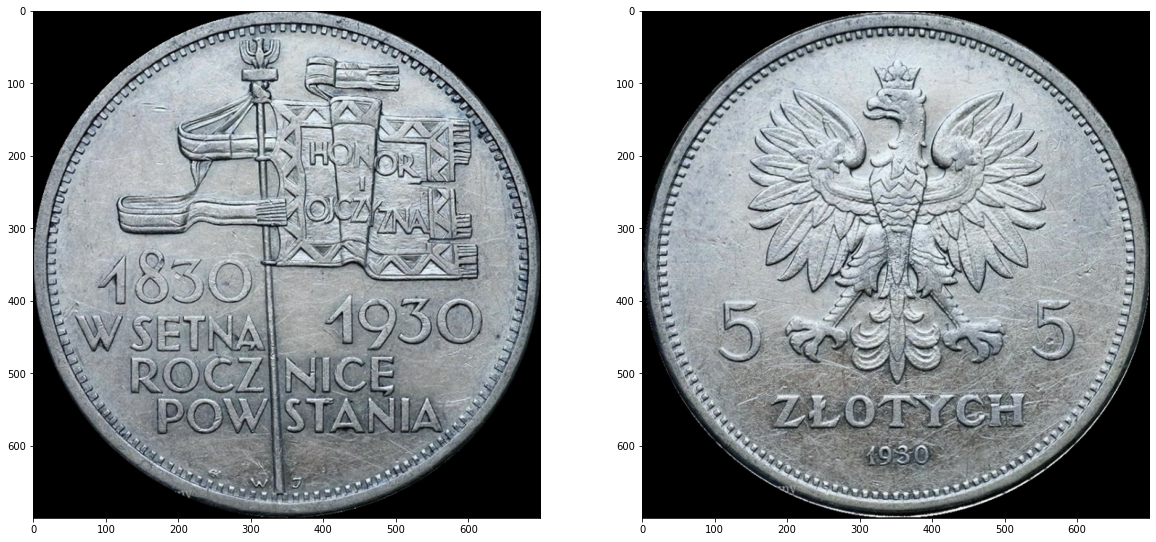

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(wear_marks_dataset.X[0], cmap='gray')
ax[1].imshow(wear_marks_dataset.X[1], cmap='gray')
plt.show()

# BoVW (Method 2)

In [ ]:
def getDescriptors(sift, img, sift_gpu):
    if sift_gpu:
      des = [kp.desc for kp in sift.keypoints(img, None)]
    else:
      kp, des = sift.detectAndCompute(img, None)
    return des

def clusterDescriptors(descriptors, no_clusters):
    kmeans = KMeans(n_clusters = no_clusters).fit(descriptors)
    return kmeans

def extractFeatures(kmeans, descriptor_list, no_clusters):
    lengths = [len(l) for l in descriptor_list]
    indices = kmeans.predict(np.vstack(descriptor_list))
    i = 0
    im_features = []
    for l in lengths:
        hist = np.histogram(indices[i:i+l], bins = np.arange(no_clusters+1))[0]
        im_features.append(hist)
        i = i + l
    return im_features

def normalizeFeatures(scale, features):
    return scale.transform(features)

def plotHistogram(im_features, no_clusters):
    x_scalar = np.arange(no_clusters)
    y_scalar = np.array([abs(np.sum(im_features[:,h], dtype=np.int32)) for h in range(no_clusters)])

    plt.bar(x_scalar, y_scalar)
    plt.xlabel("Visual Word Index")
    plt.ylabel("Frequency")
    plt.title("Complete Vocabulary Generated")
    plt.xticks(x_scalar + 0.4, x_scalar)
    plt.show()

def svcParamSelection(X, y, kernel, nfolds):
    Cs = [1.1, 0.9, 0.7, 0.5, 0.3, 0.1]
    n_features = len(X[0])
    gammas = [0.2, 0.1, 1/n_features, 2/n_features, 1/(2*n_features)]
    kernel = ['linear', 'poly', 'rbf', 'sigmoid']
    param_grid = {'C': Cs, 'kernel': kernel, 'gamma': gammas}
    
    # SVC(kernel=kernel)
    grid_search = GridSearchCV(SVC(kernel=kernel), param_grid, cv=nfolds, scoring='f1_weighted')
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

def findSVM(im_features, train_labels, kernel):
    features = im_features
    if(kernel == "precomputed"):
      features = np.dot(im_features, im_features.T)
    
    params = svcParamSelection(features, train_labels, kernel, 5)
    # C_param, gamma_param = params.get("C"), params.get("gamma")
    # print(C_param, gamma_param)
    # svm = SVC(kernel = kernel, C =  C_param, gamma = gamma_param, class_weight = 'balanced')

    C_param, kernel_param, gamma_param = params.get("C"), params.get("kernel"), params.get("gamma")
    print(C_param, kernel_param, gamma_param)
    svm = SVC(kernel = kernel_param, C = C_param, gamma=gamma_param, class_weight = 'balanced')

    svm.fit(features, train_labels)
    # print("Train accuracy", svm.score(features, train_labels))
    print("Train F1 Score ", f1_score(train_labels, svm.predict(features)), average='weighted')
    return svm

def plotConfusionMatrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
        #    xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def plotConfusions(true, predictions):
    np.set_printoptions(precision=2)
    plotConfusionMatrix(true, predictions, title='Confusion matrix, without normalization')
    plotConfusionMatrix(true, predictions, normalize=True, title='Normalized confusion matrix')
    plt.show()

def findAccuracy(true, predictions):
    print ('accuracy score: %0.3f' % accuracy_score(true, predictions))

def trainModel(X_train, y_train, no_clusters, kernel, sift_gpu, precomputed_descriptor_list=False):
    global descriptor_list, im_features

    if sift_gpu:
      sift = silx_sift.SiftPlan(template=X_train[0], devicetype="GPU")
    else:
      sift = cv2.xfeatures2d.SIFT_create()

    if not precomputed_descriptor_list or 'descriptor_list' not in globals():
        descriptor_list = []
        for x in X_train:
            des = getDescriptors(sift, x, sift_gpu)
            if des is not None and len(des) > 0:
                descriptor_list.append(des)
            else:
                descriptor_list.append(np.zeros((1,128),dtype='uint8'))


    descriptors = np.vstack(descriptor_list)
    print("Descriptors vstacked.")

    kmeans = clusterDescriptors(descriptors, no_clusters)
    print("Descriptors clustered.")

    im_features = extractFeatures(kmeans, descriptor_list, no_clusters)
    print("Images features extracted.")

    scale = StandardScaler().fit(im_features)        
    im_features = scale.transform(im_features)
    print("Train images normalized.")

    # plotHistogram(im_features, no_clusters)
    # print("Features histogram plotted.")

    svm = findSVM(im_features, y_train, kernel)
    print("SVM fitted.")

    # svm = KNeighborsClassifier(5)
    svm.fit(im_features, y_train)
    
    # print("KNN fitted.")

    print("Training completed.")

    return kmeans, scale, svm, im_features

def testModel(X_test, y_test, kmeans, scale, svm, im_features, no_clusters, kernel, sift_gpu, precomputed_descriptor_list=False):
    global descriptor_list_test

    if sift_gpu:
      sift = silx_sift.SiftPlan(template=X_test[0], devicetype="GPU")
    else:
      sift = cv2.xfeatures2d.SIFT_create()

    if not precomputed_descriptor_list or 'descriptor_list_test' not in globals():
      descriptor_list_test = []
      for x in X_test:
          des = getDescriptors(sift, x, sift_gpu)
          if des is not None and len(des) > 0:
            descriptor_list_test.append(des)
          else:
            descriptor_list_test.append(np.zeros((1,128),dtype='uint8'))

    test_features = extractFeatures(kmeans, descriptor_list_test, no_clusters)

    test_features = scale.transform(test_features)
    
    kernel_test = test_features
    if(kernel == "precomputed"):
        kernel_test = np.dot(test_features, im_features.T)
    
    predictions = svm.predict(kernel_test)
    print("Test images classified.")

    plotConfusions(y_test, predictions)
    print("Confusion matrixes plotted.")

    # findAccuracy(y_test, predictions)
    # print("Accuracy calculated.")

    print("Test F1 score: ", f1_score(y_test, predictions, average='weighted'))
    print("Execution done.")

def execute(no_clusters, kernel, sift_gpu, precomputed_descriptor_list=False):
    global wear_marks_dataset # TODO: Delete
    # wear_marks_dataset = convert_to_wear_marks_dataset(load_dataset(h5_path="dataset.h5"))
    [X_train, X_test, y_train, y_test] = train_test_split(wear_marks_dataset.X, wear_marks_dataset.y, test_size=0.3, random_state=42)
    # global kmeans, scale, svm, im_features
    kmeans, scale, svm, im_features = trainModel(X_train, y_train, no_clusters, kernel, sift_gpu, precomputed_descriptor_list=precomputed_descriptor_list)
    testModel(X_test, y_test, kmeans, scale, svm, im_features, no_clusters, kernel, sift_gpu, precomputed_descriptor_list=precomputed_descriptor_list)

In [ ]:
# dataset = load_dataset(h5_path="dataset.h5")
# wear_marks_dataset = convert_to_wear_marks_dataset(dataset)
len(im_features[0])

16

In [ ]:
%time

execute(16, 'linear', sift_gpu=True, precomputed_descriptor_list=True)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs
Descriptors vstacked.
Descriptors clustered.
Images features extracted.
Train images normalized.
0.3 poly 0.2


ValueError: ignored

## SIFT comparison

In [ ]:
class BriefDetector():
  def __init__(self):
    self.detector = cv2.xfeatures2d.StarDetector_create()
    self.extractor = cv2.xfeatures2d.BriefDescriptorExtractor_create()
  
  def detectAndCompute(self, images, kp):
    kp = self.detector.detect(images, kp)
    return self.extractor.compute(images, kp)

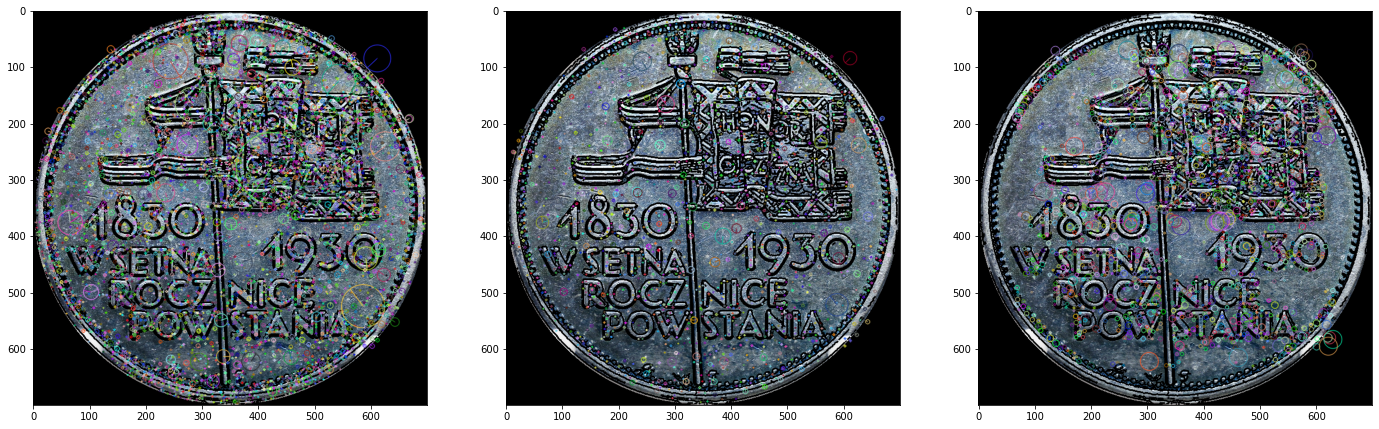

In [ ]:
img = wear_marks_dataset.X[100]
# img = cv2.resize(img, (300,300))
sift_gpu = silx_sift.SiftPlan(template=img, devicetype="GPU")
sift = cv2.xfeatures2d.SIFT_create()
brief = BriefDetector()

kp_brief, des_brief = brief.detectAndCompute(img, None)
kp, des = sift.detectAndCompute(img, None)
kp_gpu = [cv2.KeyPoint(x=p.x, y=p.y, _size=p.scale, _angle=np.rad2deg(p.angle)) for p in sift_gpu.keypoints(img, None)]

img_1 = cv2.drawKeypoints(img, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img_2 = cv2.drawKeypoints(img, kp_gpu, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img_3 = cv2.drawKeypoints(img, kp_brief, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

fig, ax = plt.subplots(1, 3, figsize=(24,8))
ax[0].imshow(img_1)
ax[1].imshow(img_2)
ax[2].imshow(img_3)
plt.show()

# CNN

In [ ]:
class CustomTensorDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        # self.targets = torch.LongTensor(targets)
        self.targets = targets
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]

        if self.transform:
            x = Image.fromarray(self.data[index])
            x = self.transform(x)
        return x, int(y-1)

    def __len__(self):
        return len(self.data)

In [ ]:
data_transforms = transforms.Compose([
        # transforms.Resize(224),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

[X_train, X_test, y_train, y_test] = \
  train_test_split(\
    wear_marks_dataset.X, wear_marks_dataset.y, test_size=0.3, random_state=42, stratify=wear_marks_dataset.y)

image_datasets = {
    "train": CustomTensorDataset(
            X_train,
            y_train,
            data_transforms
        ),
    "val": CustomTensorDataset(
            X_test,
            y_test,
            data_transforms
        )
}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2) \
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

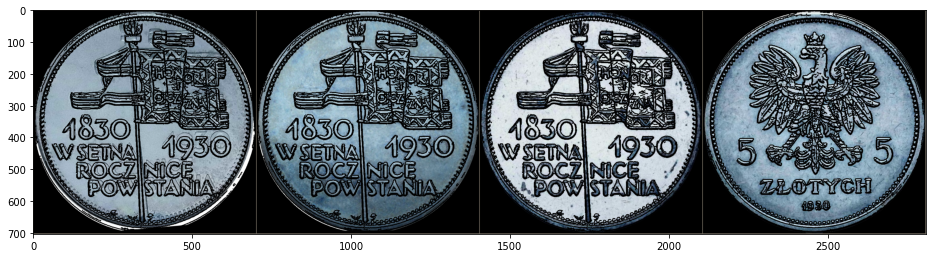

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

plt.figure(figsize=(16,5))
imshow(out)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 3)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 1.2629 Acc: 0.4433
val Loss: 1.0745 Acc: 0.5316

Epoch 1/9
----------
train Loss: 1.1149 Acc: 0.4975
val Loss: 1.1350 Acc: 0.4310

Epoch 2/9
----------
train Loss: 1.0805 Acc: 0.5148
val Loss: 1.1424 Acc: 0.3448

Epoch 3/9
----------
train Loss: 0.9945 Acc: 0.5259
val Loss: 1.0525 Acc: 0.5201

Epoch 4/9
----------
train Loss: 0.9321 Acc: 0.5837
val Loss: 1.4279 Acc: 0.2902

Epoch 5/9
----------
train Loss: 0.9158 Acc: 0.5874
val Loss: 1.2006 Acc: 0.4856

Epoch 6/9
----------
